#                            Breast Tumor Detection by Deep Learning 

# Introduction

In the realm of healthcare, early detection of cancer plays a pivotal role in ensuring the best chances of recovery and improving patient outcomes. Breast cancer, in particular, is one of the most prevalent forms of cancer affecting women worldwide. Traditional diagnostic methods, such as histopathological analysis of tissue samples, are effective but can be time-consuming and labor-intensive for medical professionals.

Advancements in machine learning and computer vision offer promising solutions to enhance the efficiency and accuracy of cancer diagnosis. By leveraging these technologies, it becomes possible to develop fast, scalable diagnostic tools capable of analyzing medical images with high precision.

Aim:

The primary aim of this project is to develop a sophisticated diagnostic tool using computer vision models. Specifically, the tool will focus on distinguishing between benign and malignant (cancerous) breast tumors based on histopathological images. Histopathology is the gold standard for diagnosing breast cancer, involving the microscopic examination of tissue samples.

By harnessing the power of machine learning algorithms and computer vision techniques, this tool seeks to automate the process of tumor classification, thereby aiding medical professionals in making accurate and timely diagnoses. Ultimately, the goal is to create a reliable and efficient system that can assist healthcare providers in identifying breast cancer at an early stage, leading to better treatment outcomes and improved patient care.

To achieve this goal, datasets have been acquired from Kaggle,https://www.kaggle.com/datasets/ambarish/breakhis a prominent platform for data science competitions and datasets. These datasets contain a comprehensive collection of histopathological images of breast tissue samples, annotated with labels indicating the presence of benign or malignant tumors.

To initiate the project, we first import essential functionalities for data manipulation, visualization, machine learning, and neural network training.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from cleanvision import Imagelab
from typing import Tuple
from matplotlib import ticker
from PIL import Image
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

This code reads a dataset from a CSV file named "Folds.csv" into a pandas DataFrame called Data. It then extracts labels from filenames in the dataset and adds them to a new column named "label" within the DataFrame. Finally, it displays the first few rows of the DataFrame to verify the addition of the label column. This preprocessing step prepares the dataset for further analysis in the context of a breast cancer detection project.

In [2]:
Data = pd.read_csv("Folds.csv")
Data["label"] = Data["filename"].str.extract("(malignant|benign)")
Data.head()

fold  mag    grp                                           filename   label
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign

This code snippet visualizes the distribution of data across different folds and the train-test split in a breast cancer detection project. It selects a specific fold, constructs file paths for the images in that fold, and creates a matplotlib figure with two subplots. The first subplot displays the count of images in each fold, with the selected fold highlighted. The second subplot visualizes the train-test split for each fold, with different colors representing training and testing data, and the selected fold highlighted. Overall, this visualization aids in understanding the dataset's characteristics and the effectiveness of the train-test split in the project.

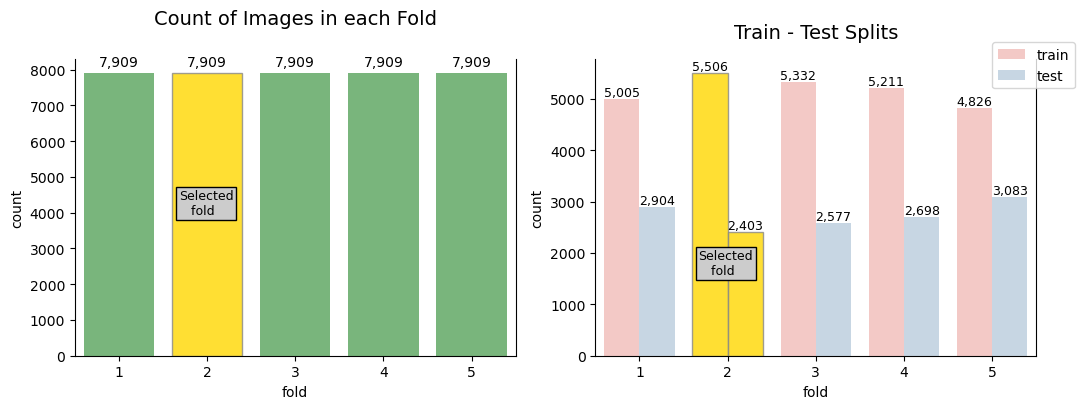

In [3]:
import matplotlib.pyplot as plt
import seaborn as sb

selected_fold = 2
selected_fold_data = Data.query("fold == @selected_fold")\
                              .copy().reset_index(drop=True)
selected_fold_data["filename"] = (r"D:\python\breast cancer detection\Dataset-/BreaKHis_v1/"
                                  + selected_fold_data["filename"])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 4.2), tight_layout=True)

# Plot image count in each fold
sb.countplot(data=Data, x="fold", color="#4CAF50", ax=ax1, alpha=0.8)  # Green color
bars = ax1.containers[0]
ax1.bar_label(bars, padding=3, labels=[f"{x:,.0f}" for x in bars.datavalues], color='black')  # Set label color to black
_selected_bar = bars[selected_fold - 1]
_selected_bar.set_facecolor("#FFD700")  # Gold color
_selected_bar.set_edgecolor("#888")
ax1.text(_selected_bar.get_x() + 0.08, _selected_bar.get_height() / 2,
         "Selected\n   fold", size=9, color="#000",  # Black color
         bbox={"pad": 2, "facecolor": "#CCCCCC"})  # Light grey background
ax1.set_title("Count of Images in each Fold", size=14, pad=25)

# Plot train-test split
sb.countplot(data=Data, x="fold", hue="grp", palette="Pastel1",  # Soft pastel colors
              ax=ax2, alpha=0.8)
for bars in ax2.containers:
    ax2.bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)
    bars[selected_fold - 1].set_facecolor("#FFD700")  # Gold color
    bars[selected_fold - 1].set_edgecolor("#888")
ax2.text(_selected_bar.get_x() + 0.07, _selected_bar.get_height() / 5,
         "Selected\n   fold", size=9, color="#000",  # Black color
         bbox={"pad": 2, "facecolor": "#CCCCCC"})  # Light grey background
ax2.set_title("Train - Test Splits", size=14, pad=15)
ax2.legend(loc=(0.9, 0.9))

# Remove top spine
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Set color of spine ticks to black for both axes
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis='y', colors='black')
ax2.tick_params(axis='x', colors='black')
ax2.tick_params(axis='y', colors='black')

plt.show()


This code generates a 2x2 grid of subplots using Matplotlib, each containing a sample image from a breast cancer dataset corresponding to different magnification levels. It selects the first image for each magnification level, displays it on its respective subplot, and annotates the subplot with the magnification level and filename. The code serves to visually inspect sample images at various magnification levels, facilitating dataset exploration for a breast cancer detection project.

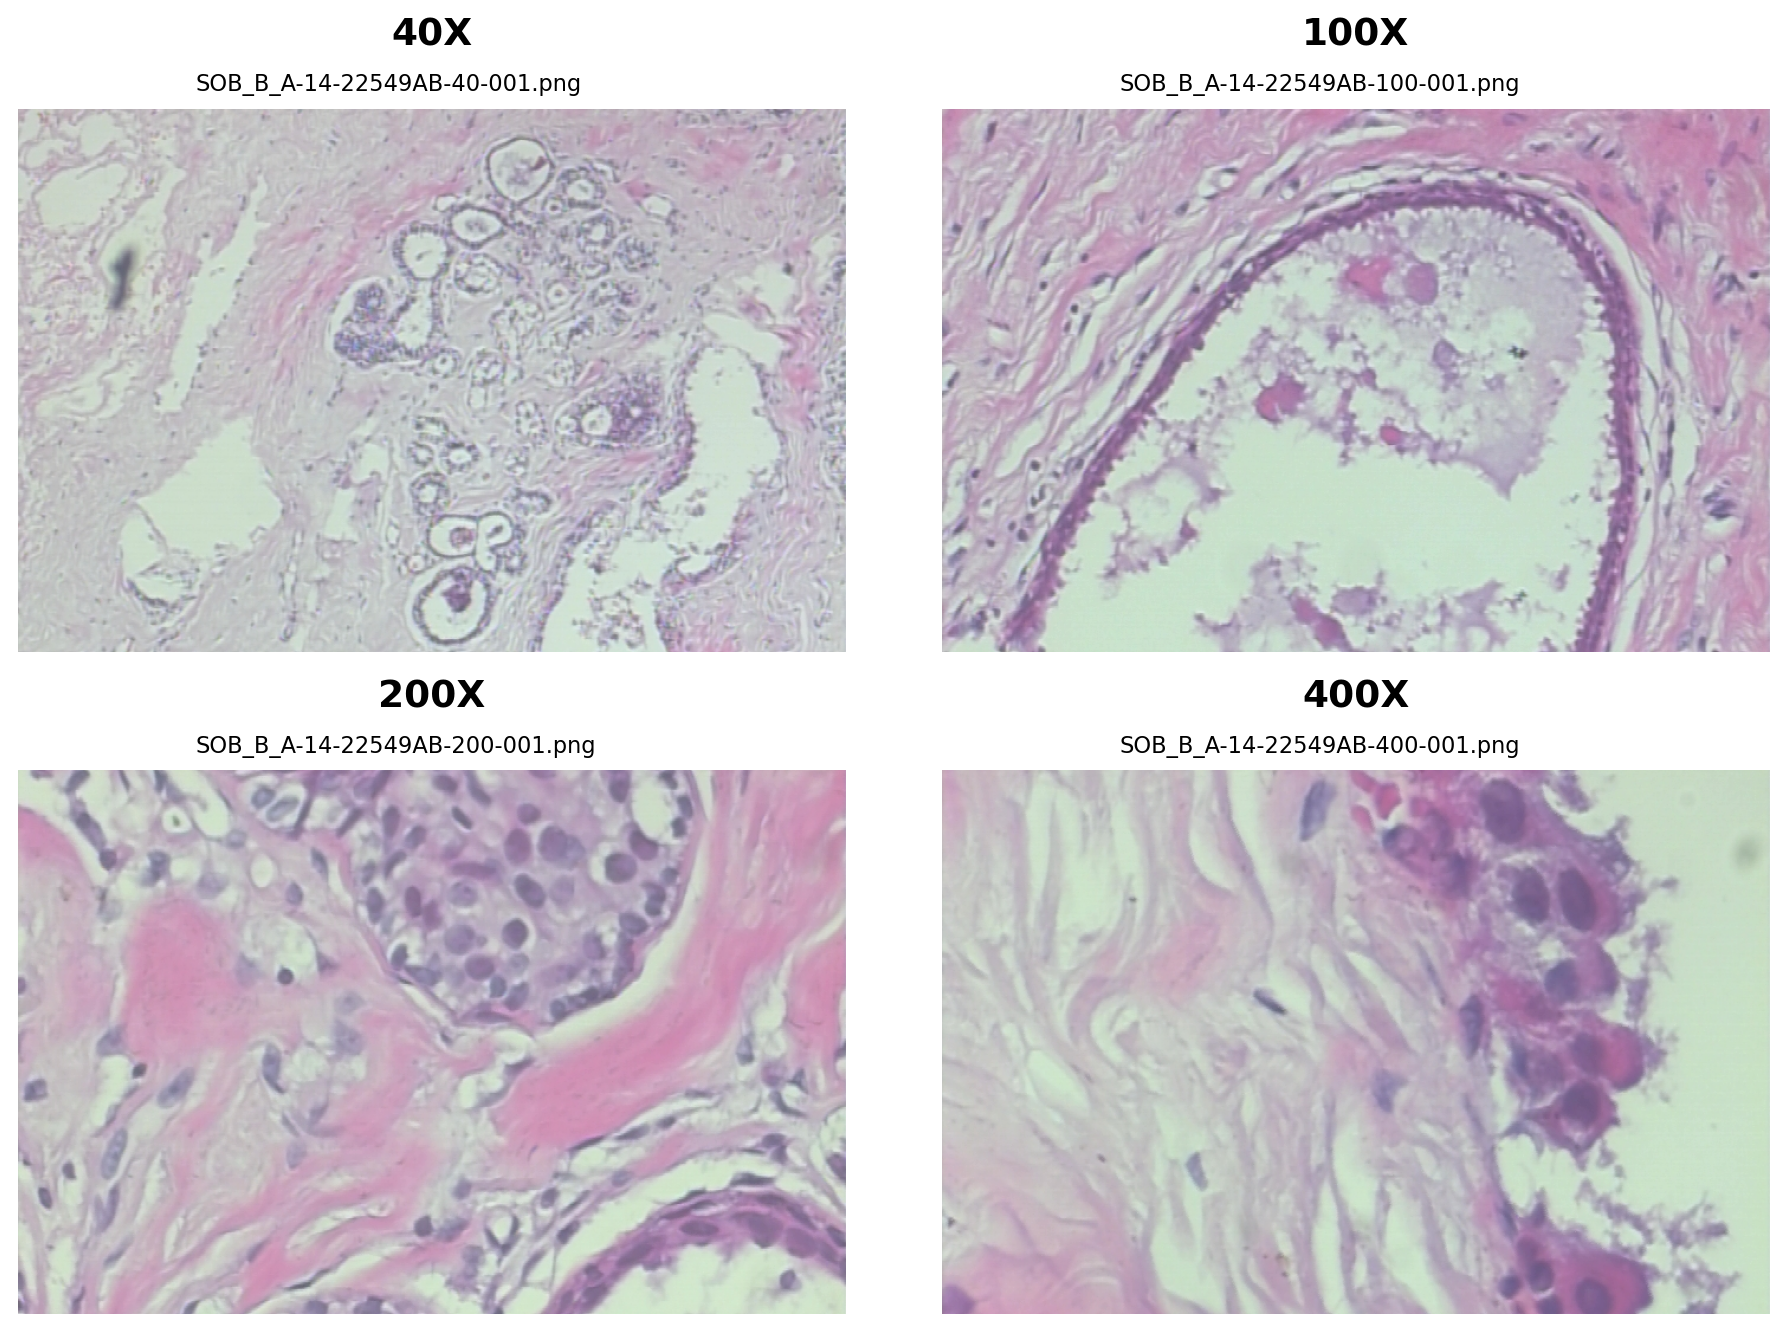

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7.5), dpi=180, tight_layout=True)
sample_images = selected_fold_data.groupby("mag", as_index=False).first()
for ax, row in zip(axes.flat, sample_images.itertuples()):
    img = Image.open(row.filename)
    ax.imshow(img)
    ax.set_title(f"{row.mag}X", size=15, pad=25, weight=600)
    ax.text(150, -15, row.filename.split("/")[-1], size=9)
    ax.axis("off")

This code segment utilizes the Imagelab class from the cleanvision library to analyze a list of image files extracted from the DataFrame selected_fold_data. Firstly, it creates an instance of Imagelab by passing the list of image file paths. Then, it invokes the find_issues() method to identify any issues or anomalies present in the images. Finally, the report() method is called with a verbosity level of 4 to generate a detailed report highlighting the issues found during the analysis. This code is particularly useful for preprocessing and quality assessment of images, which is crucial in breast cancer detection to ensure the reliability and accuracy of the dataset.

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/7909 [00:00<?, ?it/s]

  0%|          | 0/7909 [00:00<?, ?it/s]

Issue checks completed. 330 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | exact_duplicates |          250 |
|  1 | odd_size         |           74 |
|  2 | near_duplicates  |            6 |
|  3 | blurry           |            0 |
|  4 | dark             |            0 |
|  5 | grayscale        |            0 |
|  6 | light            |            0 |
|  7 | low_information  |            0 |
|  8 | odd_aspect_ratio |            0 | 

----------------- exact_duplicates images ------------------

Number of examples with this issue: 250
Examples representing most severe instances of this issue:

Set: 0


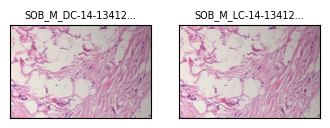

Set: 1


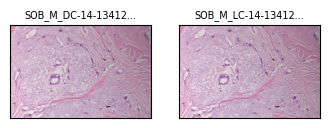

Set: 2


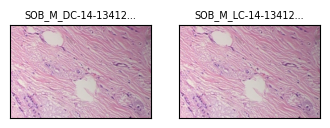

Set: 3


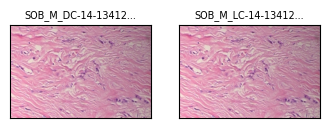

--------------------- odd_size images ----------------------

Number of examples with this issue: 74
Examples representing most severe instances of this issue:



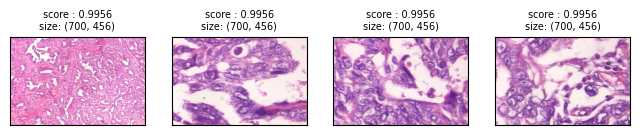

------------------ near_duplicates images ------------------

Number of examples with this issue: 6
Examples representing most severe instances of this issue:

Set: 0


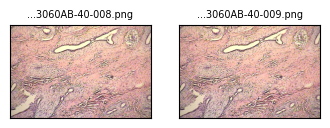

Set: 1


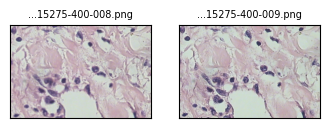

Set: 2


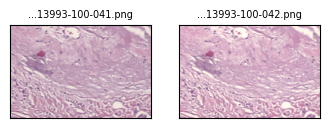

In [5]:
imagelab = Imagelab(filepaths=list(selected_fold_data["filename"]))
imagelab.find_issues()
imagelab.report(verbosity=4)

This code segment identifies and removes duplicate images from a dataset by filtering entries based on exact or near duplicate issues. It utilizes the DataFrame "imagelab.issues" to identify duplicates, removes them from "selected_fold_data", and updates the dataset accordingly. The number of removed duplicates is printed for tracking data cleanliness.

In [6]:
duplicated_images = imagelab.issues[
    ["is_exact_duplicates_issue", "is_near_duplicates_issue"]
].any(axis=1)# Filter the issues DataFrame to select only images with exact or near duplicates
duplicated_filenames = imagelab.issues[duplicated_images].index.tolist()# Get the filenames of duplicated images
filtered_data = selected_fold_data[~selected_fold_data["filename"].isin(duplicated_filenames)]# Remove duplicate images from the dataset 
num_removed_duplicates = len(selected_fold_data) - len(filtered_data)# Print the number of removed duplicate images
print(f"Removed {num_removed_duplicates} duplicate images.")
selected_fold_data = filtered_data ## Update selected_fold_data with filtered data

Removed 256 duplicate images.



This code filters the dataset selected_fold_data to create separate training and testing subsets (train and test) containing images with a magnification factor of 200X or higher. It outputs the shape of both subsets, indicating the number of images in each subset. This step ensures that only relevant images are used for training and testing , optimizing the dataset for model performance.

In [7]:
# Use data in selected fold (2) with magnification factor >= 200X
train = selected_fold_data.query("mag >= 200 and grp == 'train'")
test = selected_fold_data.query("mag >= 200 and grp == 'test'")
train.shape, test.shape

((2566, 5), (1149, 5))

This code creates a bar plot to display the distribution of classes within the training subset. It assigns numerical labels (0 for "benign" and 1 for "malignant") to the classes and generates a bar plot using Matplotlib. Each class is represented by a different color. The count and percentage of occurrences for each class are labeled on the bars. This visualization helps assess the balance of classes in the training data.

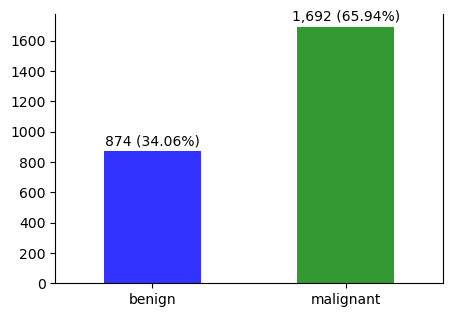

In [8]:
classes = dict(benign=0, malignant=1)
class_names = list(classes.keys())
label_counts = train["label"].value_counts(ascending=True)
ax = label_counts.plot.bar(color=["Blue", "Green"], alpha=0.8,
                           figsize=(5, 3.5))
ax.bar_label(ax.containers[0], padding=2,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in label_counts])
ax.set_xticklabels(["benign", "malignant"], rotation=0)

ax.spines['top'].set_visible(False)

plt.show()


This code calculates and prints the accuracy and ROC-AUC score for a baseline scenario where all predictions are positive. It maps class labels to numerical values, creates an array of positive predictions, and computes accuracy and ROC-AUC scores using scikit-learn functions. The results provide insights into the performance of a simple baseline model.

In [9]:
y = train["label"].map(classes)
positive_only_preds = np.ones_like(y)
print(f"Accuracy: {metrics.accuracy_score(y, positive_only_preds):.2%}",
      f"\nROC-AUC:  {metrics.roc_auc_score(y, positive_only_preds):.2%}")

Accuracy: 65.94% 
ROC-AUC:  50.00%


The code snippet ensures reproducibility and customizes matplotlib graphs for visual clarity. It sets a seed value to initialize random number generators, ensures deterministic behavior for TensorFlow operations, and customizes matplotlib settings to remove spines from axes and set font properties. These adjustments enhance the consistency and appearance of generated graphs.

In [10]:
# For reproducability
SEED = 51432
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()
# Customize matplotlib graphs
plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif", size=10.5)

The provided code generates visualizations for a confusion matrix with descriptions and various metrics plots for binary classification models. The confusion matrix is divided into four quadrants, each representing different combinations of true and predicted labels. Text descriptions are added to clarify each quadrant's meaning. Additionally, ROC curves and confusion matrices are plotted for both a positive-only predictor and a perfect predictor to evaluate model performance. These visualizations aid in assessing the accuracy and effectiveness of binary classification models in predicting outcomes.

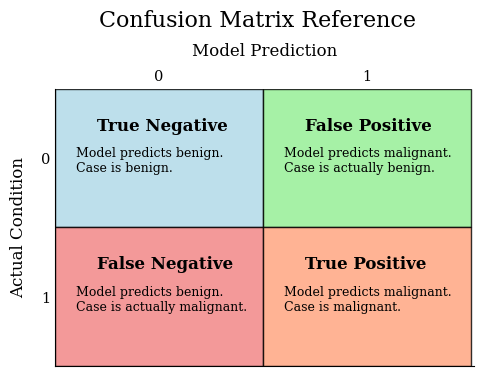

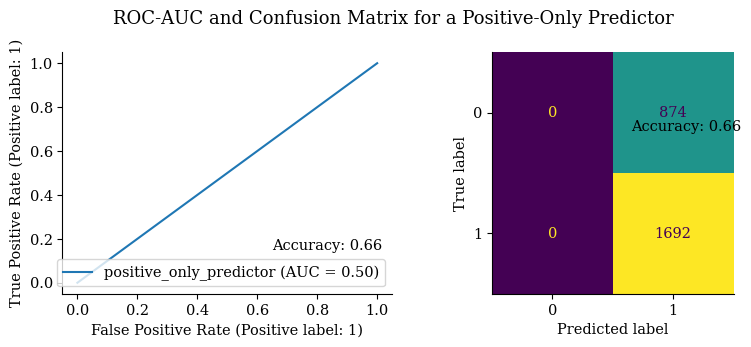

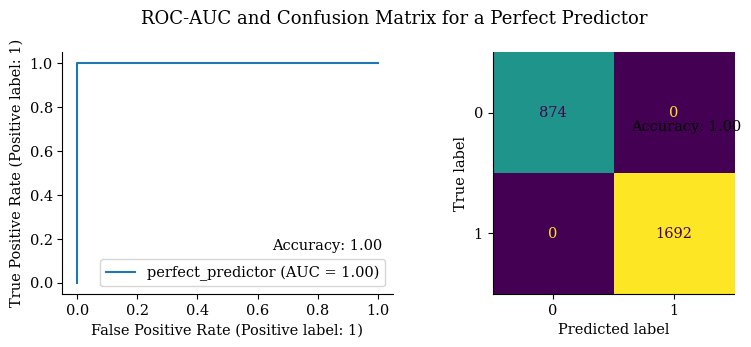

In [71]:
# Here we draw a confusion matrix with descriptions
fig, ax = plt.subplots(figsize=(5.4, 3.6))
colors = ["lightblue", "lightgreen", "lightcoral", "lightsalmon"]
positions = [(0.1, 0.85), (0.6, 0.85), (0.1, 0.35), (0.6, 0.35)]
texts = ["True Negative", "False Positive", "False Negative", "True Positive"]
descriptions = [
    ("Model predicts benign.\nCase is benign.", (0.05, 0.7)),
    ("Model predicts malignant.\nCase is actually benign.", (0.55, 0.7)),
    ("Model predicts benign.\nCase is actually malignant.", (0.05, 0.2)),
    ("Model predicts malignant.\nCase is malignant.", (0.55, 0.2))
]

for i, (x_start, x_end, y_start, y_end) in enumerate([(0, 0.5, 0.5, 1), (0.5, 1, 0.5, 1), (0, 0.5, 0, 0.5), (0.5, 1, 0, 0.5)]):
    ax.axvspan(x_start, x_end, y_start, y_end, facecolor=colors[i], alpha=0.8, edgecolor="black")
    ax.text(positions[i][0], positions[i][1], texts[i], size=12, weight=600)

for description, position in descriptions:
    ax.text(position[0], position[1], description, size=9)

ax.set_xlim(0, 1.005)
ax.xaxis.set_major_locator(ticker.FixedLocator([0.25, 0.75]))
ax.xaxis.set_ticklabels([0, 1])
ax.yaxis.set_major_locator(ticker.FixedLocator([0.25, 0.75]))
ax.yaxis.set_ticklabels([1, 0])
ax.set_ylabel("Actual Condition", size=12, labelpad=10)
ax.set_xlabel("Model Prediction", size=12, labelpad=10)
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticks_position("top")
ax.spines["left"].set_position("zero")
ax.tick_params(pad=0, top=False, left=False)
fig.suptitle("Confusion Matrix Reference", y=1.1, size=16)

# Here we plot metrics for positive-only-predictor
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)
accuracy_positive_only = metrics.accuracy_score(y, positive_only_preds)
metrics.RocCurveDisplay.from_predictions(y, positive_only_preds, ax=ax1, name="positive_only_predictor")
ax1.text(0.65, 0.15, f"Accuracy: {accuracy_positive_only:.2f}")
metrics.ConfusionMatrixDisplay.from_predictions(y, positive_only_preds, ax=ax2, colorbar=False)
ax2.text(0.65, 0.15, f"Accuracy: {accuracy_positive_only:.2f}")
fig.suptitle("ROC-AUC and Confusion Matrix for a Positive-Only Predictor", size=13)

#Here we plot metrics for "perfect" predictor
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)
accuracy_perfect = metrics.accuracy_score(y, y)
metrics.RocCurveDisplay.from_predictions(y, y, ax=ax1, name="perfect_predictor")
ax1.text(0.65, 0.15, f"Accuracy: {accuracy_perfect:.2f}")
metrics.ConfusionMatrixDisplay.from_predictions(y, y, ax=ax2, colorbar=False)
ax2.text(0.65, 0.15, f"Accuracy: {accuracy_perfect:.2f}")
fig.suptitle("ROC-AUC and Confusion Matrix for a Perfect Predictor", size=13)

plt.show()





The provided code defines a function load_image to read and preprocess images from file paths. Images are resized to a specified size (IMG_SIZE) and batched together with their corresponding labels.

Then, it splits the training data into training and validation sets using train_test_split. The function creates TensorFlow Dataset objects from the file paths and labels, applies the load_image function to preprocess the images, and batches them using the defined batch size (BATCH_SIZE).

For faster training, the data is cached, shuffled, and prefetched using TensorFlow's cache, shuffle, and prefetch methods, respectively. This optimization ensures that data is readily available for training, shuffled for better model generalization, and prefetched in the background while the model is training, reducing the time spent waiting for data during training iterations.

In [72]:
IMG_SIZE = 224
BATCH_SIZE = 28
def load_image(filename: str, label: int) -> Tuple[tf.Tensor, str]:
    file = tf.io.read_file(filename)
    img = tf.image.decode_png(file, channels=3)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
    return img, label
# Prepare training and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(
    train["filename"], train["label"].map(classes), random_state=SEED
)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
             .map(load_image).batch(BATCH_SIZE)
validation_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))\
                  .map(load_image).batch(BATCH_SIZE)
# Prepare test dataset
test = test.sample(frac=1, random_state=SEED)  # shuffle test data
test_ds = tf.data.Dataset.from_tensor_slices(
    (test["filename"], test["label"].map(classes))
).map(load_image).batch(BATCH_SIZE)

# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

The provided code snippet visualizes a sample of images from the training dataset along with their corresponding labels. Each image is displayed in a 2x5 grid, with its associated label shown as the title. Benign labels are displayed in green, while malignant labels are displayed in red. This visualization helps in understanding the appearance of images in the dataset and provides an overview of the distribution of benign and malignant cases.

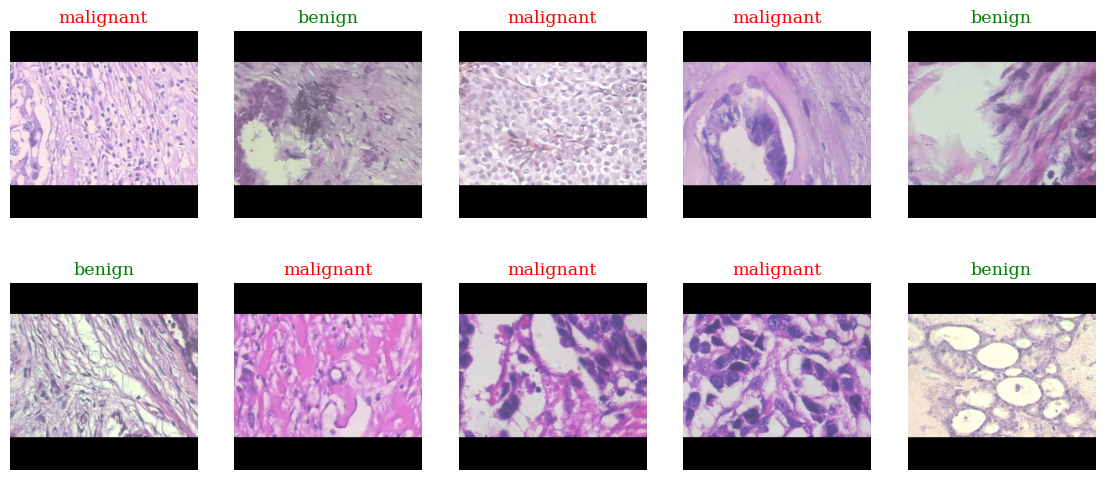

In [79]:
plt.figure(figsize=(14, 6))
for images, labels in train_ds.take(1):
    labels = labels.numpy()    
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype(np.uint8))
        label = class_names[labels[i]]
        title_color = "green" if label == "benign" else "red"
        plt.title(class_names[labels[i]], color=title_color)
        plt.axis("off")


This code defines a function plot_augmentations that visualizes image augmentations performed by a given augmentation layer. It takes an augmentation layer as input and applies it to a sample image. Then, it plots the original image and its augmented versions side by side in a row of subplots, with each subplot displaying a different augmentation. This visualization helps to understand the effects of different augmentation techniques on images.

In [80]:
sample_image = load_image(*train[["filename", "label"]].iloc[0])[0]

def plot_augmentations(augmentation_layer: tf.keras.layers.Layer) -> None:
    augment_name = augmentation_layer.name
    fig, (ax0, *axes) = plt.subplots(ncols=4, figsize=(15, 4))
    ax0.imshow(sample_image.numpy().astype("uint8"))
    ax0.set_title("Original", size=14, pad=10)
    ax0.axis("off")
    for idx, ax in enumerate(axes):
        augmented_image = augmentation_layer(sample_image)
        ax.imshow(augmented_image.numpy().astype("uint8"))
        ax.set_title(augment_name.title(), size=14, pad=10)
        ax.axis("off")

This code plots the effects of the "RandomBrightness" augmentation layer with a brightness factor of 0.2 on a sample image. It displays the original image alongside four augmented versions, each with varying brightness levels. This visualization helps understand how the RandomBrightness augmentation alters the brightness of images.

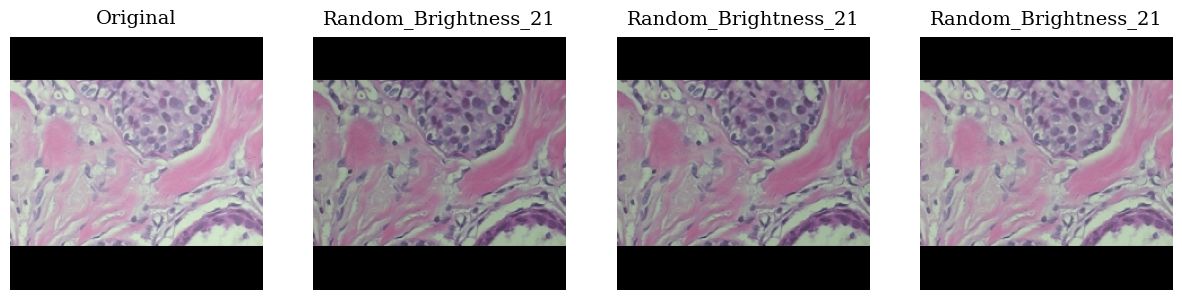

In [82]:
plot_augmentations(layers.RandomBrightness(0.2))

This code visualizes the effects of the "RandomFlip" augmentation layer, which randomly flips images horizontally or vertically. It displays the original image alongside four augmented versions, showing different combinations of horizontal and vertical flips. This visualization aids in understanding how the RandomFlip augmentation modifies the orientation of images.

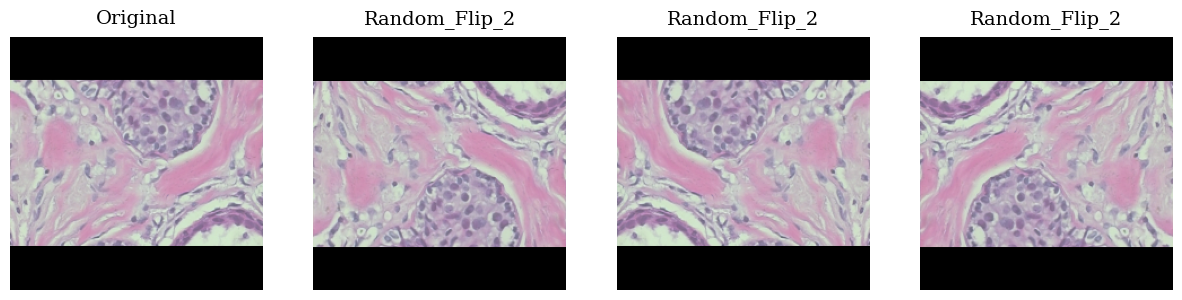

In [83]:
plot_augmentations(layers.RandomFlip())

This code visualizes the effects of the "RandomRotation" augmentation layer, which randomly rotates images within a specified range. It displays the original image alongside four augmented versions, showing different degrees of rotation. This visualization helps in understanding how the RandomRotation augmentation alters the orientation of image

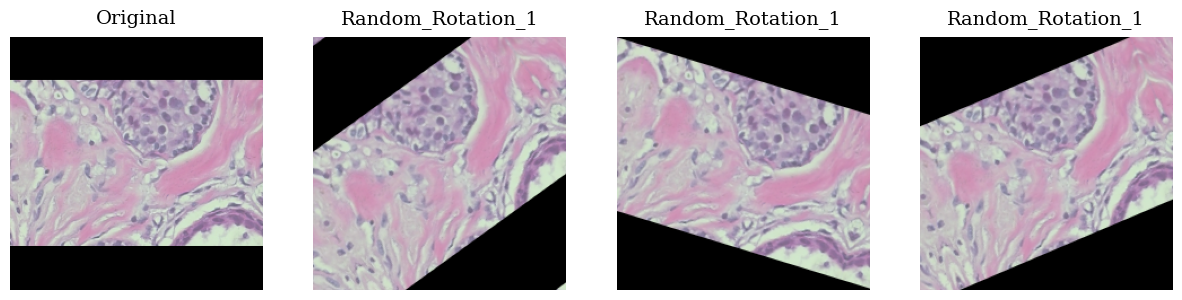

In [84]:
plot_augmentations(layers.RandomRotation(0.2, seed=SEED))

The provided code snippet outlines the construction of a Convolutional Neural Network (CNN) model optimized for image classification tasks. With a maximum of 20 training epochs and a base learning rate set to 0.001, the model architecture consists of several essential layers. These include input preprocessing such as data augmentation techniques like random brightness adjustment, flipping, and rotation, followed by normalization and batch normalization to enhance model stability. The core of the network comprises three convolutional blocks, each composed of convolutional and max-pooling layers for feature extraction and spatial dimension reduction. The model concludes with global average pooling for spatial summarization, followed by densely connected layers with rectified linear unit (ReLU) activation functions, dropout regularization, and a final sigmoid activation layer for binary classification.

In [147]:
# Define the CNN model
MAX_EPOCHS = 20
BASE_LEARNING_RATE = 0.001

# Define the CNN model
def cnn(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    model = models.Sequential([
        layers.Input(shape=input_size),
        # Data augmentation
        layers.RandomBrightness(0.2, seed=SEED),
        layers.RandomFlip(seed=SEED),
        layers.RandomRotation(0.2, seed=SEED),
        # Normalization
        layers.Rescaling(1./255),
        layers.BatchNormalization(),
        # Convolutional block I
        layers.Conv2D(32, 3, activation="relu", padding='same'),
        layers.MaxPooling2D(),
        # Convolutional block II
        layers.Conv2D(64, 3, activation="relu", padding='same'),
        layers.MaxPooling2D(),
        # Convolutional block III
        layers.Conv2D(128, 3, activation="relu", padding='same'),
        layers.MaxPooling2D(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


The provided function "compile_and_fit_model" encapsulates the process of compiling and training a Convolutional Neural Network (CNN) model for binary classification tasks. It utilizes the Adam optimizer with a specified learning rate and binary cross-entropy loss function. Additionally, it monitors two key metrics during training: the Area Under the ROC Curve (AUC) and binary accuracy. The function employs early stopping and learning rate reduction techniques, which dynamically adjust training parameters based on validation performance to prevent overfitting and accelerate convergence. The training history, containing metrics evolution across epochs, is returned for analysis and visualization.

In [139]:
# Compile and fit the CNN model
def compile_and_fit_model(model: tf.keras.Model,
                          learning_rate: float = BASE_LEARNING_RATE,
                          epochs: int = MAX_EPOCHS) -> tf.keras.callbacks.History:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.AUC(name="roc_auc"), "binary_accuracy"])
    early_stopping = EarlyStopping(min_delta=1e-4, patience=5, verbose=1,
                                   restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=4, verbose=1)
    history = model.fit(train_ds, validation_data=test_ds,
                        epochs=epochs, callbacks=[early_stopping, reduce_lr])
    return history


The "evaluate_model" function is designed to assess the performance of a TensorFlow Keras model on a given dataset. It computes the loss, Area Under the ROC Curve (ROC-AUC), and accuracy metrics for the provided model on the dataset. Additionally, it visualizes several performance metrics, including the ROC-AUC curve, precision-recall curve, and confusion matrix, to provide comprehensive insights into the model's behavior. These visualizations aid in understanding the model's strengths and weaknesses and help in diagnosing potential issues such as overfitting or class imbalance. Overall, the function facilitates a thorough evaluation of the model's predictive capabilities and assists in making informed decisions regarding model selection and fine-tuning.

In [140]:
# Function to evaluate the model
def evaluate_model(model: tf.keras.Model, dataset: tf.data.Dataset) -> None:
    loss, auc, accuracy = model.evaluate(dataset, verbose=0)
    print(f"\nROC-AUC:   {auc:.5f}", 
          f"Accuracy:  {accuracy:.5f}",
          f"Loss:      {loss:.5f}\n", sep="\n")
    # Get labels and predictions for each batch in dataset
    results = [(labels.numpy(), model.predict(images).reshape(-1))
               for images, labels in dataset.take(-1)]
    labels = np.concatenate([x[0] for x in results])
    preds = np.concatenate([x[1] for x in results])
    # Plot metrics
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4), dpi=160)
    for ax, curve in zip(axes[:2], [metrics.RocCurveDisplay, metrics.PrecisionRecallDisplay]):
        curve.from_predictions(labels, preds, ax=ax, name=model.name)
    metrics.ConfusionMatrixDisplay.from_predictions(
        labels, preds.round().astype("uint8"), ax=axes[2], colorbar=False)
    titles = ["ROC-AUC Curve", "Precision-Recall Curve", "Confusion Matrix"]
    for ax, title in zip(axes.flat, titles):
        ax.set_title(title, size=14, pad=10)

The "plot_predictions" function is designed to visualize the predictions made by a TensorFlow Keras model on a given dataset. It creates a grid of subplots to display a selection of images along with their corresponding predicted and actual labels. For each image, the function compares the predicted label with the actual label and assigns a title to the subplot accordingly. If the prediction matches the ground truth, the title is displayed in green, indicating a correct prediction. Otherwise, the title is shown in red, highlighting a discrepancy between the predicted and actual labels. This visualization aids in assessing the model's performance qualitatively by providing insights into its ability to correctly classify different samples in the dataset.

In [141]:
# Function to plot predictions
def plot_predictions(model: tf.keras.Model) -> None:
    plt.figure(figsize=(14, 9))
    for images, labels in test_ds.take(1):
        labels = labels.numpy()
        predicted_labels = model.predict(images).round().astype("uint8").reshape(-1,)
        print("Predicted:", predicted_labels)
        print("Actual:   ", labels)
        for i, (pred, actual) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(4, 7, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if pred == actual:
                plt.title(class_names[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_names[predicted_labels[i]]}\n"
                          + f"(Actual: {class_names[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

The evaluate_and_plot function serves to assess the performance of the model and visualize its training progress. Initially, it evaluates the model's effectiveness on a designated test dataset using the evaluate_model function. Subsequently, it generates two separate plots using the Matplotlib library. The first plot illustrates the training and validation loss throughout the training epochs, where the x-axis represents the epochs and the y-axis indicates the corresponding loss values. The validation loss is distinguished by a different color for clarity. Following that, the second plot showcases the training and validation accuracy over epochs, employing a similar axis configuration as the loss plot. These visualizations aid in comprehending the model's learning process, facilitating the identification of potential issues such as overfitting or underfitting. Lastly, the function demonstrates its usage by instantiating a convolutional neural network model (cnn_model) employing a predefined architecture.

In [8]:
# Function to evaluate the model and plot training/validation loss and accuracy
def evaluate_and_plot(model: tf.keras.Model, history: tf.keras.callbacks.History, test_ds: tf.data.Dataset) -> None:
    # Evaluate the model
    evaluate_model(model, test_ds)

    # Plot training and validation loss over epochs
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy over epochs
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

The cnn_model.summary() method provides a concise overview of the architecture of a convolutional neural network (CNN) model. It displays a tabular representation detailing the various layers in the model along with their output shapes and the number of parameters in each layer. This summary helps in understanding the composition of the neural network, including the type and sequence of layers used, the dimensions of the feature maps produced by each layer, and the total number of trainable parameters in the model. Additionally, it facilitates debugging and optimization by allowing quick inspection of the model's structure and parameter count.

In [143]:
cnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_32 (Rando  (None, 224, 224, 3)      0         
 mBrightness)                                                    
                                                                 
 random_flip_13 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_12 (RandomR  (None, 224, 224, 3)      0         
 otation)                                                        
                                                                 
 rescaling_10 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 batch_normalization_10 (Bat  (None, 224, 224, 3)      12        
 chNormalization)                                                
                                                     

Epoch 1/20
69/69 [==============================] - 131s 2s/step - loss: 0.5326 - roc_auc: 0.7802 - binary_accuracy: 0.7484 - val_loss: 0.5945 - val_roc_auc: 0.8284 - val_binary_accuracy: 0.7084 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - 126s 2s/step - loss: 0.4221 - roc_auc: 0.8643 - binary_accuracy: 0.8399 - val_loss: 0.4764 - val_roc_auc: 0.8148 - val_binary_accuracy: 0.8407 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - 121s 2s/step - loss: 0.4101 - roc_auc: 0.8677 - binary_accuracy: 0.8508 - val_loss: 0.4500 - val_roc_auc: 0.8101 - val_binary_accuracy: 0.8520 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - 121s 2s/step - loss: 0.4100 - roc_auc: 0.8698 - binary_accuracy: 0.8378 - val_loss: 0.4829 - val_roc_auc: 0.8049 - val_binary_accuracy: 0.8164 - lr: 0.0010
Epoch 5/20
69/69 [==============================] - 120s 2s/step - loss: 0.4015 - roc_auc: 0.8733 - binary_accuracy: 0.8462 - val_loss: 0.4616 - val_roc_auc: 0.8121 - v

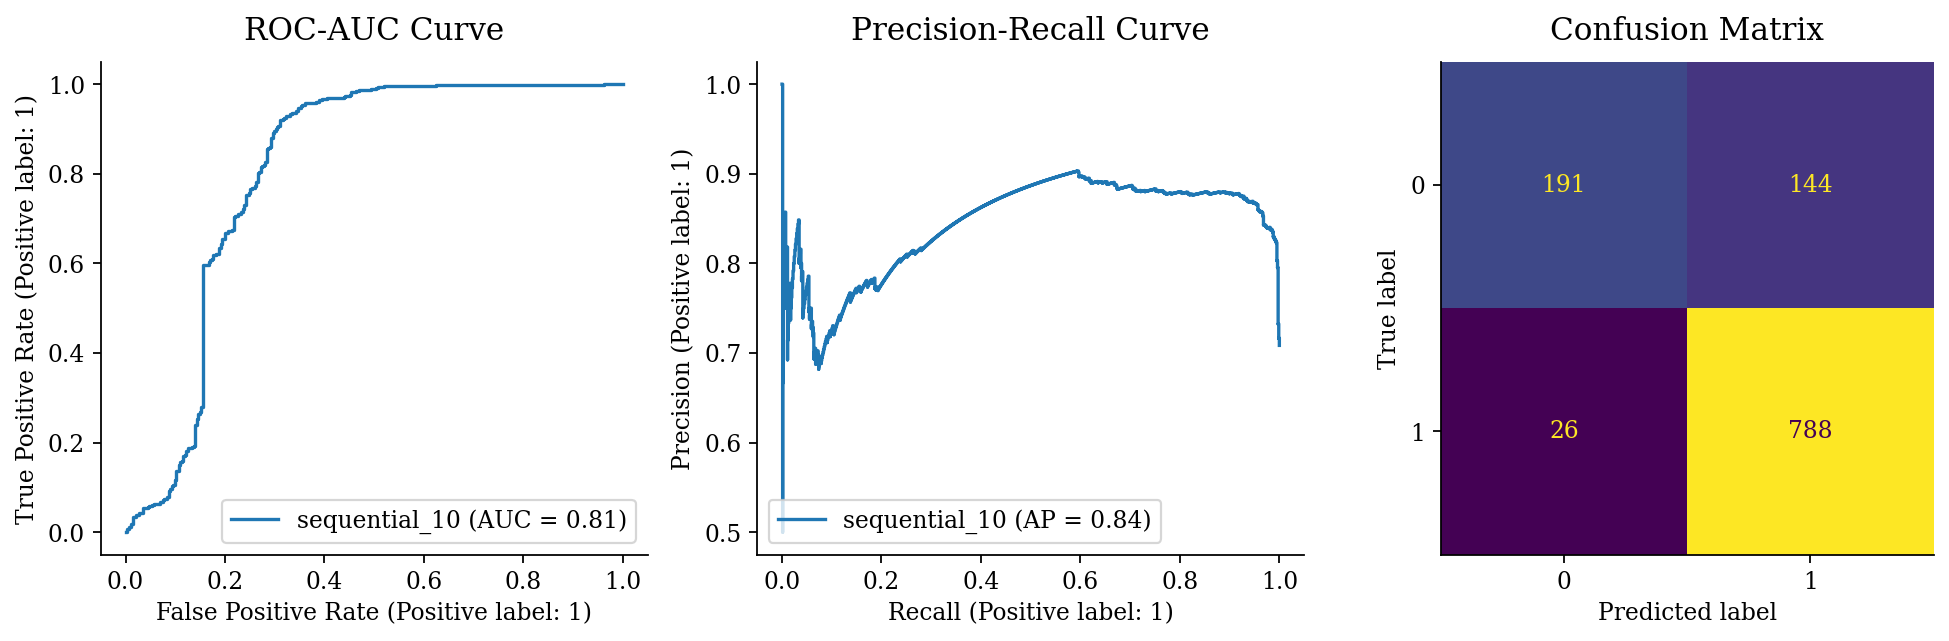

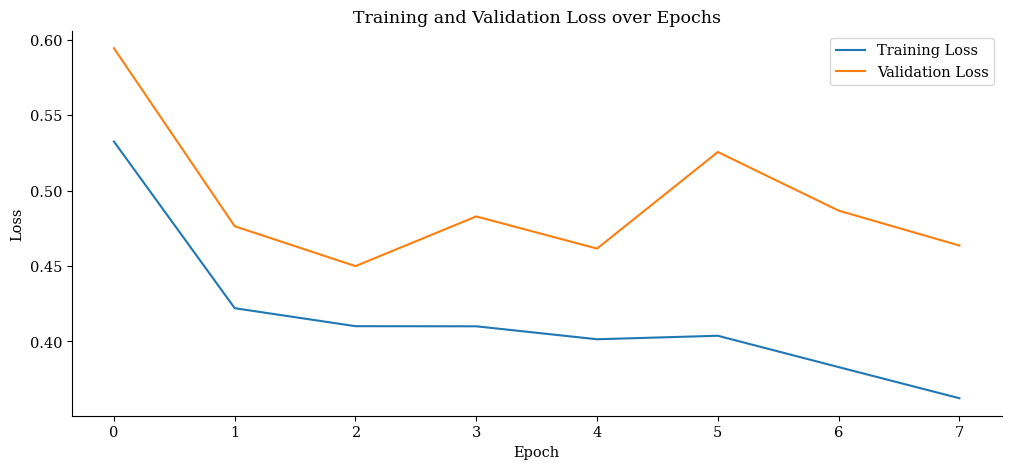

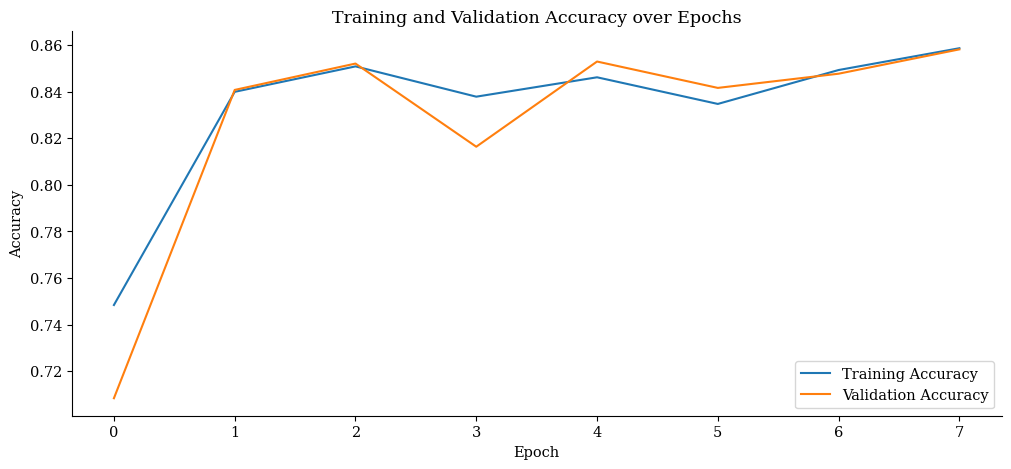

In [144]:
history = compile_and_fit_model(cnn_model)
evaluate_and_plot(cnn_model, history, test_ds)

1/1 [==============================] - 0s 281ms/step
Predicted: [1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0]
Actual:    [1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0]


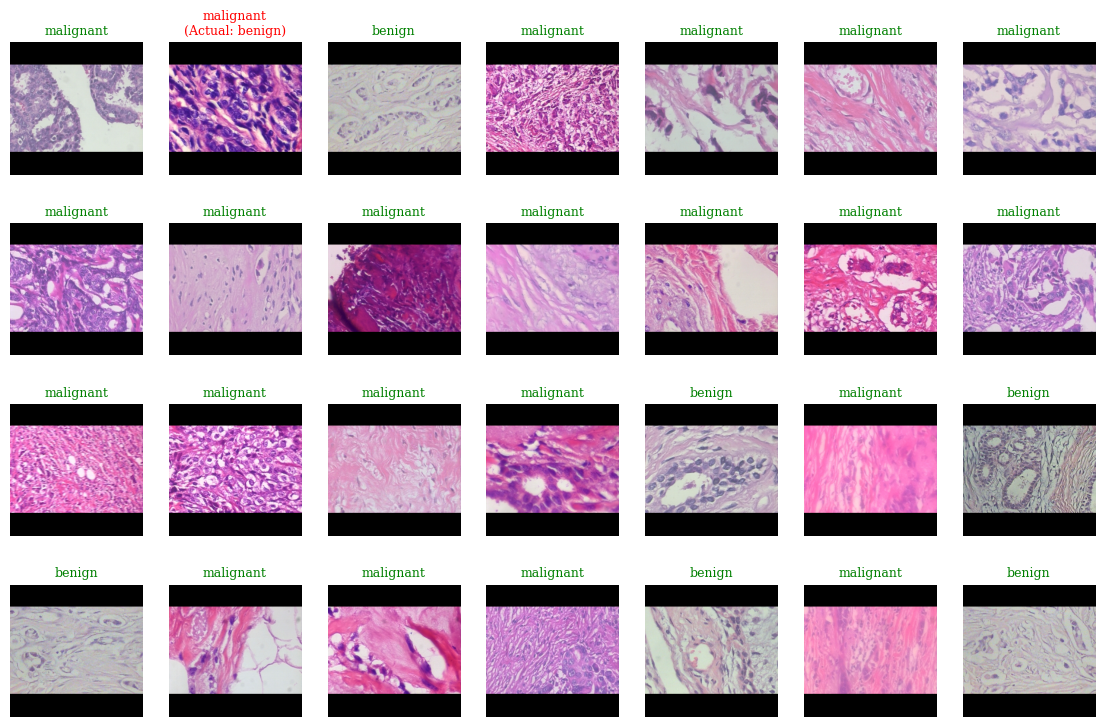

In [146]:
plot_predictions(cnn_model)

The evaluation results indicate promising performance of the breast tumor detection model based on deep learning using histopathological images datasets. The ROC-AUC score of 0.81005 suggests that the model demonstrates good discrimination ability between positive and negative tumor instances. Additionally, achieving an accuracy of 0.85205 indicates that the model can correctly classify a significant proportion of the samples. However, the loss value of 0.44998 suggests that there is room for improvement in minimizing the error between predicted and actual labels.

Overall, these evaluation metrics suggest that the developed deep learning model shows potential for effectively detecting breast tumors from histopathological images. 